In [2]:
import pandas as pd
from cmapPy.pandasGEXpress.parse_gct import parse
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
import numpy as np
import urllib.request, json
import requests
import matplotlib.pyplot as plt

In [3]:
data_parse = parse('../data/countMatrix.gct')
data = data_parse.data_df.T

In [4]:
def scale_data(data):
    return (data - data.mean()) / (data.max() - data.min())

In [41]:
samples = data.index.values
negative_sample_names = []
positive_sample_names = []
core_sample_names = []
for sample_name in samples:
    if "neg" in sample_name:
        negative_sample_names.append(sample_name)
    if "pos" in sample_name:
        positive_sample_names.append(sample_name)
    if "1" in sample_name:
        core_sample_names.append(sample_name)

In [43]:
scaled_data = scale_data(data)
negative_samples = data.loc[negative_sample_names]
positive_samples = data.loc[positive_sample_names]
core_samples = data.loc[core_sample_names]
scaled_negative = scaled_data.loc[negative_sample_names]
scaled_positive = scaled_data.loc[positive_sample_names]
scaled_core = scaled_data.loc[core_sample_names]
negative_samples.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']
positive_samples.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']
core_samples.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']
scaled_negative.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']
scaled_positive.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']
scaled_core.index = ['27', '28', '29', '30', '31', '33', '34', '37', '38', '40']

In [7]:
expression_differential = negative_samples - positive_samples
mean_difference = expression_differential.mean()

In [8]:
mean_difference.sort_values(ascending=False)

rid
HBB       25867.667969
HBA2      16855.988281
HBA1      14685.716797
S100A9     7191.857910
S100A8     4922.477051
              ...     
APOE      -3879.011719
C1QA      -5043.845215
C1QB      -5382.215820
CCL4      -9430.874023
CCL3     -14621.046875
Length: 13475, dtype: float32

In [9]:
linear_model = LinearRegression()
top_coef = 0
top_gene = ""
gene_correlation = pd.DataFrame(columns=['Score'])
for gene_name in data.columns.values:
    if 0 in (negative_samples[gene_name] + positive_samples[gene_name]).values:
        continue
    all_samples_shaped = negative_samples[gene_name].append(positive_samples[gene_name]).values.reshape(-1, 1)
    linear_model.fit(all_samples_shaped, ([0] * negative_samples.shape[0]) + [1] * positive_samples.shape[0])
    coef = linear_model.coef_
    gene_correlation.loc[gene_name] = coef
    if coef > top_coef:
        top_coef = coef
        top_gene = gene_name
        print("Gene Name: {0} has correlation: {1}".format(gene_name, coef))

Gene Name: A4GALT has correlation: [0.01247817]
Gene Name: AANAT has correlation: [0.0154294]
Gene Name: ABCA4 has correlation: [0.05367116]
Gene Name: ADH1B has correlation: [0.06064701]
Gene Name: ANKDD1B has correlation: [0.22173338]
Gene Name: C12orf42 has correlation: [0.2722553]
Gene Name: FAM225A has correlation: [0.3383364]
Gene Name: GRINA has correlation: [0.4603218]
Gene Name: RENBP has correlation: [0.7222639]


In [46]:
# 5ALA +ve vs -ve SVM
svc = LinearSVC()
top_score = 0
top_gene = ""
svc_correlation = pd.DataFrame(columns=['Score'])
for gene_name in data.columns.values:
    if 0 in scaled_negative[gene_name].values or 0 in scaled_positive[gene_name].values:
        continue
    if np.sum(scaled_negative[gene_name] + scaled_positive[gene_name]) == 0:
        continue
    all_samples_shaped = scaled_negative[gene_name].append(scaled_positive[gene_name]).values.reshape(-1, 1)
    labels = ([0] * negative_samples.shape[0]) + [1] * positive_samples.shape[0]
    svc.fit(all_samples_shaped, labels)
    score = svc.score(all_samples_shaped, labels)
    svc_correlation.loc[gene_name] = score
    if score > top_score:
        top_score = score
        top_gene = gene_name
        print("Gene {0} has score {1}".format(gene_name, svc.score(all_samples_shaped, labels)))

Gene A1CF has score 0.6
Gene AADAT has score 0.65
Gene ABCA8 has score 0.75
Gene ACYP1 has score 0.8
Gene MDK has score 0.85
Gene TOR4A has score 0.9


In [45]:
# 5ALA +ve vs Core SVM
svc = LinearSVC()
top_score = 0
top_gene = ""
core_svc = pd.DataFrame(columns=['Score'])
for gene_name in data.columns.values:
    if 0 in scaled_core[gene_name].values or 0 in scaled_positive[gene_name].values:
        continue
    if np.sum(scaled_core[gene_name] + scaled_positive[gene_name]) == 0:
        continue
    all_samples_shaped = scaled_core[gene_name].append(scaled_positive[gene_name]).values.reshape(-1, 1)
    labels = ([0] * scaled_core.shape[0]) + [1] * positive_samples.shape[0]
    svc.fit(all_samples_shaped, labels)
    score = svc.score(all_samples_shaped, labels)
    core_svc.loc[gene_name] = score
    if score > top_score:
        top_score = score
        top_gene = gene_name
        print("Gene {0} has score {1}".format(gene_name, svc.score(all_samples_shaped, labels)))

Gene A1CF has score 0.55
Gene AAAS has score 0.85
Gene ABAT has score 0.9
Gene ARHGEF25 has score 0.95


In [11]:
def find_available_samples(sorted_gene_list, n):
    found_n = 0
    searched = 0
    for gene_name in sorted_gene_list.index.values:
        fetch_samples_url = "http://api.brain-map.org/api/v2/data/query.json?criteria=model::SectionDataSet,rma::criteria,treatments[name$eq\'ISH\'],genes[acronym$eq\'{0}\'],rma::include,genes,sub_images".format(gene_name)
        with urllib.request.urlopen(fetch_samples_url) as url:
            raw_json = json.loads(url.read().decode())
            searched += 1
            if raw_json['num_rows'] > 0:
                found_n += 1
                print("{0} ({1}) has {2} samples after searching {3}".format(gene_name, sorted_gene_list.loc[gene_name][0], raw_json['total_rows'], searched))
            if found_n >= n:
                break

In [12]:
# Find Difference Samples
find_available_samples(mean_difference.sort_values(ascending=False), 5)

IndexError: invalid index to scalar variable.

In [13]:
# Find Linear Regression Samples
gene_correlation_sorted = gene_correlation.sort_values(by='Score', ascending=False)
find_available_samples(gene_correlation_sorted, 10)

GRINA (0.4603218138217926) has 5 samples after searching 2
TACR2 (0.20790375769138336) has 3 samples after searching 11
CPNE6 (0.06988568603992462) has 5 samples after searching 50
SYT16 (0.06678924709558487) has 5 samples after searching 54
ADH1B (0.060647010803222656) has 8 samples after searching 64
LGI1 (0.05298793688416481) has 6 samples after searching 72
IGF1 (0.04611663147807121) has 6 samples after searching 78
DSP (0.0443209707736969) has 12 samples after searching 79


KeyboardInterrupt: 

In [19]:
# Find SVM Samples
svc_correlation_sorted = svc_correlation.sort_values(by='Score', ascending=False)
find_available_samples(svc_correlation_sorted, 25)

SRP9 (0.8) has 6 samples after searching 13
RPS6 (0.8) has 5 samples after searching 41
SLN (0.75) has 6 samples after searching 47
PAM (0.75) has 6 samples after searching 49
NR4A2 (0.75) has 102 samples after searching 54
HDAC1 (0.75) has 8 samples after searching 57
SERPINF1 (0.75) has 8 samples after searching 61


KeyboardInterrupt: 

In [54]:
core_vs_positive_svc = pd.DataFrame(columns=['Score'])
for gene_name in svc_correlation.index.values:
    core_vs_positive_svc.loc[gene_name] = core_svc.loc[gene_name] + svc_correlation.loc[gene_name]
core_vs_positive_svc.sort_values(by='Score', ascending=False)

,Score
SRP9,1.75
TMEM240,1.75
CSRNP1,1.70
PRDX2,1.70
COPS8,1.70
...,...
GPALPP1,0.65
ZBTB3,0.65
SLC66A1L,0.65
MRPL39,0.55


In [66]:
core_svc_sorted = core_svc.sort_values(by='Score', ascending=False)

core_svc_sorted.head(25)

,Score
CCDC34,0.95
TCEA2,0.95
BCAM,0.95
HMGB1,0.95
PDCD2L,0.95
SLC41A3,0.95
RRH,0.95
PLAUR,0.95
CD320,0.95
NFKBIA,0.95


In [25]:
svc_correlation_sorted.head(15)

,Score
TOR4A,0.90
SF3B6,0.85
TRPM2,0.85
MDK,0.85
SLC37A2,0.80
DNAJA4,0.80
COPS8,0.80
EIF3H,0.80
RPL10A,0.80
EXOSC1,0.80


In [34]:
svc_correlation_sorted.loc["OCIAD2"]

Score    0.75
Name: OCIAD2, dtype: float64

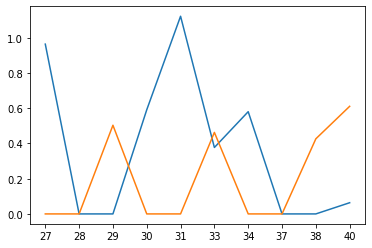

In [57]:
# %5ALA +ve vs -ve
target_gene = "RRH"
plt.plot(negative_samples[target_gene])
plt.plot(positive_samples[target_gene])
plt.show()

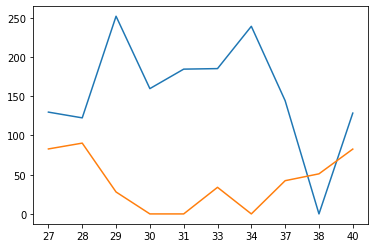

In [59]:
# %5ALA +ve vs Core
target_gene = "CD320"
plt.plot(core_samples[target_gene])
plt.plot(positive_samples[target_gene])
plt.show()

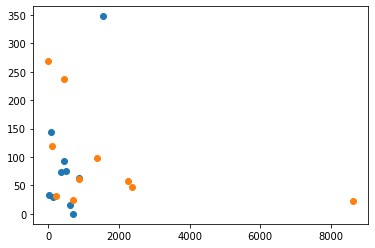

In [18]:
target_gene1 = "CCL2"
target_gene2 = "CD44"
plt.scatter(negative_samples[target_gene1], negative_samples[target_gene2])
plt.scatter(positive_samples[target_gene1], positive_samples[target_gene2])
plt.show()